<a href="https://colab.research.google.com/github/atedstone/unil_envi_ggl_hydrology_practicals/blob/main/excess_melt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical: Retention of Greenland runoff by refreezing

In this practical we will use equations originally presented by Pfeffer et al. (1991) to identify the areas of the Greenland Ice Sheet most likely to undergo runoff. For more recent studies which use this approach, see MacFerrin et al. (2019) and Tedstone & Machguth (2022).

### References

Pfeffer, W., M. Meier and T. Illangasekare (1991). Retention of Greenland Runoff by Refreezing: Implications for Projected Future Sea Level Change. Journal of Geophysical Research, 96 (C12), 22117-22124.

MacFerrin, M., Machguth, H., van As, D., Charalampidis, C., Stevens, C. M., Heilig, A., Vandecrux, B., Langen, P. L., Mottram, R., Fettweis, X., van den Broeke, M. R., Pfeffer, W. T., Moussavi, M. S., and Abdalati, W. (2019) Rapid expansion of Greenland's low-permeability ice slabs. Nature, 573 (7774), 403-407.

Tedstone, A. and Machguth, H. (2022). Increasing surface runoff from Greenland's firn areas. Nature Climate Change, 12, 672-676.


In [1]:
# Install ipympl so that we can use interactive plots
!pip install ipympl
# And activate in Colab
from google.colab import output
output.enable_custom_widget_manager()

**Important!** If this is the first time you are running the Notebook, restart your session now using the menu 'Runtime... Restart session'. You don't need to run the above cell again afterwards, you can continue with the rest of the Notebook.

### Python imports

In [2]:
# For downloading the practical data from remote link
import requests
import os

In [3]:
# Libraries for analysis
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib widget

### Load the regional climate model data
We will use these data as inputs for the calculations.

In [4]:
nc_filename = 'MARv3.14.3-10km-ERA5-EMvars-2018-2019.nc'
if os.path.exists(nc_filename):
    print('File already downloaded.')
else:
    print('Downloading...')
    URL = 'https://unils-my.sharepoint.com/:u:/g/personal/andrew_tedstone_unil_ch/ESoBLfXwchBCmxjczBzlT04BmAoMHJCR1H9tzmuLHW0yww?download=1'
    response = requests.get(URL)
    open(nc_filename, 'wb').write(response.content)
    print('Done.')

Downloading...
Done.


In [5]:
data = xr.open_dataset('MARv3.14.3-10km-ERA5-EMvars-2018-2019.nc')

Take a moment to familiarise yourself with the contents of this dataset by executing the cell below.

In [6]:
data

<xarray.Dataset> Size: 2MB
Dimensions:    (TIME: 2, SECTOR1_1: 1, y: 270, x: 150)
Coordinates:
  * TIME       (TIME) datetime64[ns] 16B 2018-08-31 2019-08-31
  * SECTOR1_1  (SECTOR1_1) float32 4B 1.0
  * y          (y) float32 1kB -3.348e+03 -3.338e+03 ... -667.9 -657.9
  * x          (x) float32 600B -640.0 -630.0 -620.0 ... 830.0 840.0 850.0
    ZTQLEV     float32 4B ...
Data variables:
    ME         (TIME, SECTOR1_1, y, x) float32 324kB ...
    RF         (TIME, y, x) float32 324kB ...
    SF         (TIME, y, x) float32 324kB ...
    TT         (TIME, y, x) float32 324kB ...
    SH         (y, x) float32 162kB ...
    LAT        (y, x) float32 162kB ...
    LON        (y, x) float32 162kB ...
    MSK        (y, x) float32 162kB ...
    crs        int64 8B ...

There are some useful things to notice and think about:

- We have two `TIME` points; 2018-08-31 and 2019-08-31. Why do we want to use 'end of August' data?
- There is a data variable `MSK`, which has values running from 0-100 but does *not* have a `TIME` dimension. Plot it below to understand what this variable contains.

End of August: end of the summer (meltwater >>)

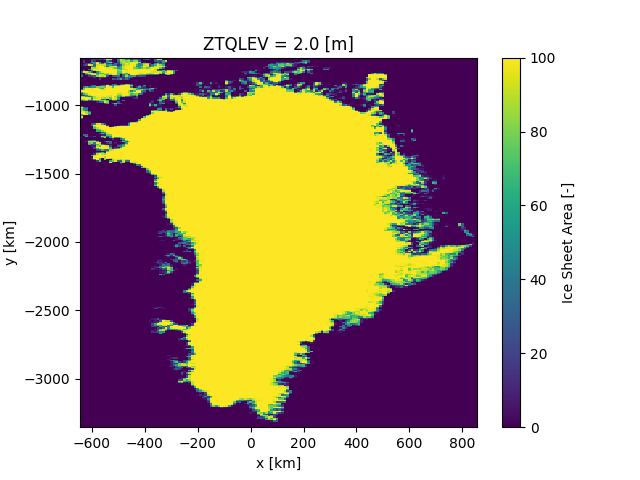

In [7]:
data.MSK.plot()

### Accounting for varying snow density across the ice sheet

Here we use the snow density parameterization from Langen, et al. (2017, Frontiers in Earth Science) eq. 17:

    Freshly-fallen snow has an initial density parameterized through
    a linear regression of surface density observations onto surface
    elevation, zsrf (m a.s.l.), latitude, ϕ (degrees north), and longitude,
    λ (degrees east).

In other words, the density of Greenland snow varies according to elevation and location.

Parameters `a,b,c,d` below describe this relationship empirically.

In [8]:
a_rho = 328.35
b_rho = -0.049376
c_rho = 1.0427
d_rho = -0.11186

# Now make the x/y grid of snow density.
rho_snow = (a_rho + b_rho*data.SH + c_rho*data.LAT + d_rho*data.LON)

### Calculate the pore space available for meltwater refreezing

In [9]:
# Firn pore close-off density, kg/m3
rho_closeoff = 830.
# Calculate the snow pore space available to be filled by refreezing water until the pores close.
Z = (rho_closeoff - rho_snow)/rho_snow

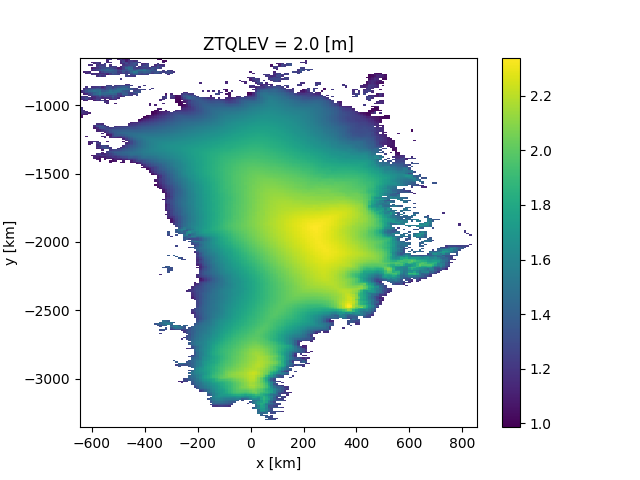

In [10]:
# In this plot, a value > 1 means that pore space is available for filling.
plt.figure()
Z.where(data.MSK > 50).plot()

A map of pore space generate in winter that could be fill up with melt water

### Calculate the cold content of the pore space

This is done as a function of the average annual air temperature.

In [11]:
# Heat capacity of ice, kJ/(kg *C)
c = 2.108
# Latent heat of fusion of ice, kJ/kg
L = 333.55

# The t_annual value is used to calculate firn/snow temperatures.
# For this calculation, null-out any average temperatures above zero (should be none for the ice sheet).
t_annual = data.TT.where(data.TT < 0)

# Now calculate the cold content of the pore space available for refreezing surface meltwater.
Q = (c/L) * -1.0*t_annual # Expressed in *positive* degrees below zero.

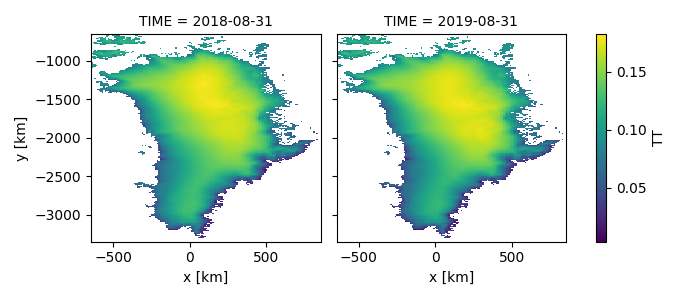

In [12]:
# Let's plot these cold content data.
# Notice that we supply col='TIME', which says to use the columns of the figure to show the different TIME points.
Q.where(data.MSK > 50).plot(col='TIME')

### Calculate the Melt/Accumulation ratio

In [13]:
# (Cold content + available pore space) * ((1 + available pore space)**-1)
MC_ratio = (Q + Z) * ((1 + Z)**-1)

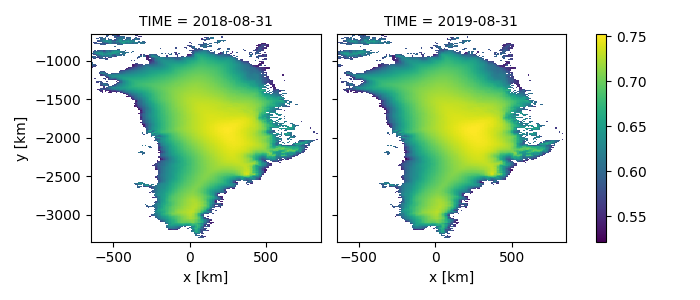

In [14]:
MC_ratio.where(data.MSK > 50).plot(col='TIME')
# This should roughly correspond with the basic necessary condition for runoff that (melt / accumulation >= 0.7)

### Calculate excess melt

The units here are mm water equivalent per year, because we are working with data at annual resolution.

In [15]:
# Calculate the melt in excess of that which can be contained in the pores --> this water will run off.
excess_melt = (
    ((data.ME+data.RF)/data.SF) - MC_ratio
    ) * data.SF

# So far this is in millimetres water equivalent as these are the units of the regional climate model data
# Let's convert to m w.e
excess_melt = excess_melt * 0.001

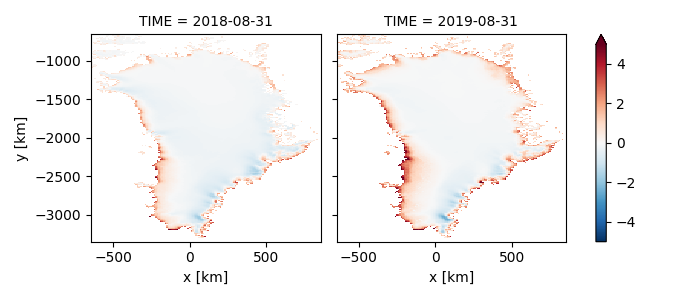

In [16]:
# Red values = excess melt available, likely to for runoff.
# units: millimetres water equivalent
excess_melt.where(data.MSK > 50).plot(col='TIME', vmin=-5, vmax=5, cmap='RdBu_r')

--> high values in the margin of the ice sheet because no pore space available > potential runoff. Negative values = accumulation zones

--> the differences between the two year depend on summer melt condition

### Some questions to consider

1. According to these calculations, how big is the ice sheet's annual runoff area? How could you calculate this? (Hint: some kind of threshold calculation)

In [17]:
# Calculate the runoff area for each time step where excess_melt is greater than 0
runoff_area = (excess_melt > 0).sum(dim=['x', 'y'])

print("Annual runoff area (number of grid cells where excess_melt > 0):")
display(runoff_area)

Annual runoff area (number of grid cells where excess_melt > 0):


<xarray.DataArray (TIME: 2, SECTOR1_1: 1)> Size: 16B
array([[14305],
       [14586]])
Coordinates:
  * TIME       (TIME) datetime64[ns] 16B 2018-08-31 2019-08-31
  * SECTOR1_1  (SECTOR1_1) float32 4B 1.0
    ZTQLEV     float32 4B 2.0

Text(0.5, 1.02, 'Annual Runoff Area (where excess_melt > 0)')

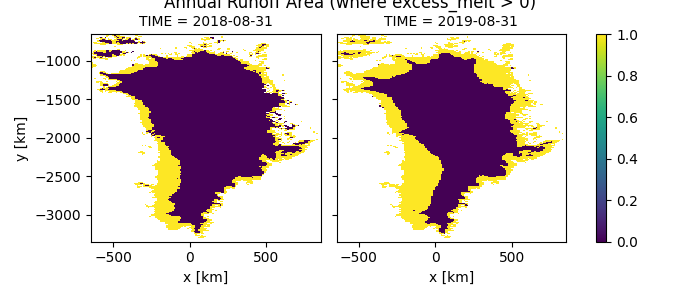

In [18]:
# Create a plot to visualize the runoff area
# We can use the boolean mask (excess_melt > 0) to show the runoff areas
(excess_melt > 0).where(data.MSK > 50).plot(col='TIME')
plt.suptitle('Annual Runoff Area (where excess_melt > 0)', y=1.02)

2. What is more important in explaining the variability that we see between years: (1) accumulation or (2) melt?